---
# Spatial Pooler
- SDR (Sparse Destribution Representation, 희소 분포 표상) 생성
- 입력에 대해 pooler 를 이루고 있는 column 들의 일부 (=~2% 내외) 만 활성화 한다
- 모든 column 이 비슷한 빈도로 active 되어야함
- 모든 column 의 synapse 들이 비슷한 빈도로 active 되어야함


- [x] 1-d array column structure
- [x] potential synapse - make tunable, randomly
- [ ] hard testing
- [ ] visualizing method
- [x] 학습 기능 on/off 구현
- [x] boost factor 목표치
- [x] activate duty 목표치 안정화

# SDR 의 조건
- The first property of the SP is to form fixed-sparsity representations of the input.
- A second desirable property is that the system should utilize all available resources to learn optimal representations of the inputs.
- A third desirable property is that output representations should be robust to noise in the inputs.
- A fourth property is that the system should be flexible and able to adapt to changing input statistics.
- Finally, a fifth property is that the system should be fault tolerant.

---

- sparsity 는 0.2 에 밀집되어야 함

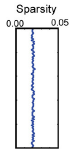

In [10]:
from IPython.display import Image
Image("C:\\Users\\김민수\\Desktop\\HTM\\sparsity.png")

- active duty 이 아래처럼 평균 0.2 에 밀집되어야 함

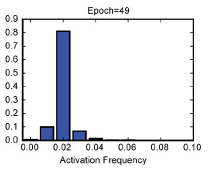

In [11]:
Image("C:\\Users\\김민수\\Desktop\\HTM\\activateDuty.png")

- active duty 에 따른 각 column 당 boost factor 조절값

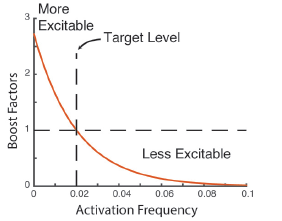

In [2]:
Image("C:\\Users\\김민수\\Desktop\\HTM\\boostFactor.png")

In [95]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import math
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import nbimporter
import Encoder
import random
import time

In [398]:
class SpatialPooler:
    def __init__(self, input_size, columns=100, conPerm=.7, minOver=5, potential_rate=.8):
        self.input_size = input_size                               # input vector 크기
        self.input_data = np.empty([self.input_size])              # encoding 된 input vector
        self.columnCount = columns                                 # column 의 크기 - 1d array
        self.connectedPerm = conPerm                               # synapse 활성화(1) 될 permanence 임계치
        self.min_overlap = minOver                                 # 발화 하기 위한 컬럼 당 최소한의 overlap count
        self.minGlobalActivity = 0                                 # 승리하기 위해 필요한 score (global inhibition)
        self.desiredGlobalActivity = int(0.02 * self.columnCount)  # 한 번에 승리할 column 수 (global inhibition), 2 % 만 발화
        self.minDutyCycle = 0                                      # column 당 최소 발화 duty
        self.highDutyCycle = 0
        self.permanence_inc = .05                                  # 학습시 permanence 증가량
        self.permanence_dec = .05                                  # 학습시 permanence 감소량
        self.history_capacity = 200                                # duty 계산할 history 용량
        self.step = 0                                              # 데이터 처리한 수
        self.potential_rate = potential_rate                       # 입력 데이터에 대한 potential synapses 의 비율
        self.potential_count = int(self.input_size*self.potential_rate)    # potiential synapses 갯수. 이외의 입력값에는 전혀 연결성이 없다.
        
        self.potential_synapses = np.random.random([self.input_size, self.columnCount])   # potential synapses(proxiaml dendrite) - permanence ndarry. 초기화 필요      
        self.connected_synapses = np.zeros([self.input_size, self.columnCount])           # permanence 가 높아 연결된 synapses
        self.boosts = np.ones([self.columnCount])                                         # 보정에 필요한 boost factor
        self.overlapped = np.zeros([self.columnCount])                                    # input 과 연결된 synapse 들과의 최초 계산
        self.activeColumns = np.zeros([self.columnCount])                                 # 활성화된 columns
        self.activeHistory = []                                            # active duty 를 계산하기 위한 active 기록
        self.overlapHistory = []                                           # overlap duty 를 계산하기 위한 overlap 기록
        self.activeDutyInfo = np.zeros([self.columnCount])                 # active duty 정보
        self.overlapDutyInfo = np.zeros([self.columnCount])                # overlap duty 정보
        
        
        # potential synapses 구성
        for col in range(self.columnCount):
            never_connect = self.input_size - self.potential_count

            while(never_connect > 0):
                idx = random.randint(0, self.input_size - 1)

                if(self.potential_synapses[idx, col] != -1):
                    self.potential_synapses[idx, col] = -1
                    never_connect -= 1
        
        ## duty 계산을 위한 history 생성 ##
        for c in range(self.columnCount):
            self.activeHistory.append(collections.deque())
            self.overlapHistory.append(collections.deque())
            
                
    ''' SDR 생성 '''
    def compute_SDR(self, input_data, learn=True):
        
        self.input_data = input_data
        
        ## 1. overlaping ##
        self.connected_synapses = self.potential_synapses > self.connectedPerm
        self.overlapped = self.input_data @ self.connected_synapses
        
        for c in range(self.columnCount):
            if(self.overlapped[c] > self.min_overlap):
                self.overlapped[c] *= self.boosts[c]

                if(len(self.overlapHistory[c]) >= self.history_capacity):
                    self.overlapHistory[c].popleft()

                self.overlapHistory[c].append(True)

            else:
                self.overlapped[c] = 0

                if(len(self.overlapHistory[c]) >= self.history_capacity):
                    self.overlapHistory[c].popleft()

                self.overlapHistory[c].append(False)
                    
                    
        ## 2. inhibition (global) ##
        self.minGlobalActivity = self.kthScore(self.desiredGlobalActivity)
        self.activeColumns = self.overlapped >= self.minGlobalActivity
        
        for c in range(self.columnCount):                
            if(len(self.activeHistory[c]) >= self.history_capacity):
                self.activeHistory[c].popleft()

            self.activeHistory[c].append(self.activeColumns[c])
                    
                
        ## 3. learning ## 
        if(learn):
            for c in range(self.columnCount):

                if(self.activeColumns[c] == 1):
                    for s in range(self.input_size):

                        if(self.potential_synapses[s, c] != -1):
                            if(self.input_data[s] == 1):
                                self.potential_synapses[s, c] += self.permanence_inc
                                self.potential_synapses[s, c] = min(self.potential_synapses[s, c], 1.0)
                            else:
                                self.potential_synapses[s, c] -= self.permanence_dec
                                self.potential_synapses[s, c] = max(0.0, self.potential_synapses[s, c])


        self.update_activeDuty()
        self.update_overlapDuty()
        self.step += 1
        
        ## 3.2. 보정 작업 ##
        if(learn):
            for c in range(self.columnCount):
                ## 자주 승리하지 못하는 column 에 대하여 잘 발화할 수 있도록 boost 시켜줌
                maxDuty, highDuty = self.maxhighDutyCycle()
                self.minDutyCycle = .01 * maxDuty
                self.highDutyCycle = highDuty
                #print("min :", self.minDutyCycle)
                self.boostFunction(c)
                #print(self.boosts)

                ## input 과 잘 겹치지 않는 synapse 에 대해서 permanence 증가시켜줌
                if(self.overlapDutyInfo[c] < self.minDutyCycle):
                    self.increase_Permanence(c)
                    #print("min", self.minDutyCycle)

                
# ----------------------------------- helper method ---------------------------------------- #
# ------------------------------------------------------------------------------------------ #

    ''' global 하게 승리할 컬럼의 기준 '''
    def kthScore(self, desired_kth):
        
        rank = self.overlapped.ravel().copy()
        rank.sort()        
        score = rank[-desired_kth]
        
        return score
    
    
    ''' global 하게 가장 자주 승리한 컬럼의 duty '''
    def maxhighDutyCycle(self):
        
        rank = self.activeDutyInfo.ravel().copy()
        rank.sort()
        maxDuty = rank[-1]
        highDuty = rank[-int(self.input_size/5)]
        
        return maxDuty, highDuty
    
    
    
    ''' 해당 column 이 발화하도록 격려 '''
    def boostFunction(self, c):
        
        x = self.activeDutyInfo[c]
        
        if(x > .02):
            self.boosts[c] = -5*x + 1.1
        else:
            self.boosts[c] = -75*x + 2.5
            
            
            
    ''' 해당 column 의 모든 petential synapse 의 permanence 를 증가시켜 잘 겹치도록 격려 '''
    def increase_Permanence(self, c):
        for s in range(self.input_size):
            if(self.potential_synapses[s, c] != -1):
                self.potential_synapses[s, c] += self.permanence_inc
        
        
    ''' activeDuty update '''
    def update_activeDuty(self):
        for c in range(self.columnCount):
            self.activeDutyInfo[c] = np.mean(self.activeHistory[c])

                
    ''' overlapDuty update '''
    def update_overlapDuty(self):
        for c in range(self.columnCount):
            self.overlapDutyInfo[c] = np.mean(self.overlapHistory[c])
    
    
    ''' SDR 시각화 출력 '''
    def visualize_SDR(self):
        #fig = plt.figure(figsize=(20,1))
        #plt.imshow(self.activeColumns.reshape(1, self.columnCount))
        #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        #cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        #plt.colorbar(cax=cax)
        #plt.show()
        
        sparsity = (np.count_nonzero(self.activeColumns==True)/(self.columnCount))
        return sparsity
    
    
# ----------------------------------- Test & Visualization Methods ---------------------------------------- #
# ------------------------------------------------------------------------------------------ #
    
    ''' Testing & Visualization '''
    # 검증 tool 스크립트로 옮길 예정
    
    
    ''' active columns 반환 '''
    def getActiveColumns(self):
        return self.activeColumns
    
    
    
    ''' 두 SDR 의 유사도 반환 & 시각화 '''
    def similarity(self, SDR_1, SDR_2):
        
        N = self.columnCount
        img_1 = np.zeros([1, N, 4], dtype=np.uint8)
        img_2 = np.zeros([1, N, 4], dtype=np.uint8)
        
        output_notebook()
        
        for i in range(N):
            if(SDR_1[i]):
                img_1[0, i, 0:3] = 0 # r

            else:
                img_1[0, i, 0:3] = 255 # r

                
            img_1[0, i, 3] = 255 # a
            
        for i in range(N):
            if(SDR_2[i]):
                img_2[0, i, 0] = 0 # r
                img_2[0, i, 1] = 0 # g
                img_2[0, i, 2] = 0 # b
            else:
                img_2[0, i, 0] = 255 # r
                img_2[0, i, 1] = 255 # g
                img_2[0, i, 2] = 255 # b
                
            img_2[0, i, 3] = 255 # a
            
            

        p = figure(plot_width=1000, plot_height=100, x_range=(0, self.columnCount*2/100), y_range=(0, 1))
        p2 = figure(plot_width=1000, plot_height=100, x_range=p.x_range, y_range=p.y_range)
        
        p.image_rgba(image=[img_1], x=[0], y=[0], dw=[10], dh=[10])
        p2.image_rgba(image=[img_2], x=[0], y=[0], dw=[10], dh=[10])

        show(gridplot([[p],[p2]]))
        
        # 유사도 = 1 이면, 두 sdr 완벽히 일치
        print("유사도 :", np.count_nonzero(SDR_1 & SDR_2) / np.count_nonzero(SDR_1 | SDR_2))

        idx = []
        idx2 = []
        for i in range((self.columnCount)):
            if(SDR_1[i] == 1):
                idx.append(i)
                
        for i in range((self.columnCount)):
            if(SDR_2[i] == 1):
                idx2.append(i)
                
        print(idx)
        print(idx2)

        
        
    ''' 같은 입력에 대해서 같은 출력을 내는 정도  '''
    def consistency(self, data, num):
        
        mismatch = 0
        sdr = None
        
        self.compute_SDR(data, False)
        sdr_prev = self.getActiveColumns()
        
        for i in range(num):
            self.compute_SDR(data, False)
            sdr = self.getActiveColumns()
            mismatch += np.count_nonzero(sdr ^ sdr_prev)
            sdr_prev = sdr.copy()
            
        # 오류 0 이면 모든 테스트케이스에 대하여 동일한 출력.
        print("오류 :", mismatch / (self.desiredGlobalActivity*num))
            
            
    
    def noiseRobustness(self):
        # noise 에 대해 견고성 테스트 결과
        pass
    
    def falseRobustness(self):
        # 오류에 대해 견고성 테스트 결과
        pass
    
    
                        
    ''' active columns(SDRs), overlap 카운트  '''                    
    def viz_activeCol(self):
        N = self.columnCount
        img = np.zeros([1, N, 4], dtype=np.uint8)
        
        maxOverlap = np.sort(self.overlapped).copy()[-1]
        
        for i in range(N):
            if(self.activeColumns[i]):
                img[0, i, 0:3] = 0 # r

            else:
                img[0, i, 0:3] = 255 # r
                
            
            img[0, i, 3] = np.sqrt(self.overlapped[i]/maxOverlap) * 255 # a
        # 
        p = figure(plot_width=1000, plot_height=100, x_range=(0, self.columnCount*2/100), y_range=(0, 1))
        p.image_rgba(image=[img], x=[0], y=[0], dw=[10], dh=[10])
        show(p)
        
        idx = []
        for i in range((self.columnCount)):
            if(self.activeColumns[i] == 1):
                idx.append(i)
        print("active columns : {} \ncount : {}".format(idx, np.count_nonzero(self.activeColumns)))
        
    
    def viz_NetState(self):
        # SDR 의 현재 상태
        # active duty, overlap duty, sparsity 평균, 표준편차
        # permanenece, boost factor
        pass
    
    
    
    
    def test(self):
        idx = []
        for i in range(len(self.activeColumns)):
            if(self.activeColumns[i] == 1):
                idx.append(i)
                
        return idx

In [399]:
sp = SpatialPooler(128, 512, .7, 3, potential_rate=.6)
se = Encoder.ScalarEncoder(out_size=128, max_val=30, w=20)

In [400]:
step = 10
encoded_data = 0
y=np.empty([step])

start = time.time()
for i in range(step):
    rand = random.randint(0, se.max_val)
    encoded_data = se.encode(rand)
    sp.compute_SDR(encoded_data)
    #y[i] = sp.visualize_SDR()
    
print(time.time() - start, 'encoding + compute + record 된 소요시간')
#plt.plot(range(step), y)

0.5336709022521973 encoding + compute + record 된 소요시간


In [401]:
sp.viz_activeCol()

active columns : [23, 31, 37, 42, 50, 53, 117, 144, 167, 188, 191, 263, 333, 370, 382, 406, 493, 497, 508] 
count : 19


In [357]:
sp.consistency(se.encode(1), 10)

오류 : 0.0


In [339]:
sp.compute_SDR(se.encode(1), False)
sdr1 = sp.getActiveColumns()
sp.compute_SDR(se.encode(1), False)
sdr2 = sp.getActiveColumns()
sp.similarity(sdr1, sdr2)

Loading BokehJS ...

유사도 : 1.0
[30, 63, 64, 74, 75, 128, 152, 155, 193, 199, 241, 268, 278, 281, 318, 425, 477, 480]
[30, 63, 64, 74, 75, 128, 152, 155, 193, 199, 241, 268, 278, 281, 318, 425, 477, 480]


In [7]:
for i in range(1, se.max_val):
    sp.compute_SDR(se.encode(i), False)
    #sp.visualize_SDR()
    print(sp.test())
    
#sp.compute_SDR(se.encode(3))
#sp.visualize_SDR()

print("boost : \n", sp.boosts)
print("-"*50 + '\n')
print("-> 평균 : {}, 표준편차 : {}\n".format(sp.boosts.mean(), sp.boosts.std()))
print("active : \n", sp.activeDutyInfo)
print("-"*50 + '\n')
print("-> 평균 : {}, 표준편차 : {}\n".format(sp.activeDutyInfo.mean(), sp.activeDutyInfo.std()))
print("overlap : \n", sp.overlapDutyInfo)
print("-"*50 + '\n')
print("-> 평균 : {}, 표준편차 : {}\n".format(sp.overlapDutyInfo.mean(), sp.overlapDutyInfo.std()))

[29, 48, 196, 212, 259, 287, 296, 327, 392, 410, 416, 425, 455, 472, 500]
[62, 190, 212, 223, 260, 380, 410, 411, 491, 502]
[35, 157, 212, 236, 355, 373, 395, 411, 438, 491]
[6, 55, 212, 236, 270, 359, 369, 373, 387, 411, 438, 452]
[6, 35, 58, 108, 150, 163, 236, 330, 366, 387, 418]
[6, 35, 46, 58, 108, 150, 163, 330, 366, 387, 440]
[46, 58, 103, 150, 153, 198, 199, 266, 286, 292, 337, 366, 440]
[44, 60, 122, 155, 207, 241, 247, 250, 292, 326, 379, 384, 408]
[27, 44, 155, 204, 241, 247, 326, 354, 456, 462]
[24, 136, 143, 155, 241, 247, 280, 301, 345, 352]
[24, 27, 28, 55, 91, 143, 181, 221, 241, 247, 280, 328, 345, 484]
[24, 155, 181, 241, 280, 315, 328, 336, 393, 458]
[24, 70, 72, 111, 167, 200, 336, 388, 398, 445]
[24, 111, 167, 169, 177, 189, 200, 308, 445, 458, 511]
[45, 64, 111, 117, 189, 200, 269, 335, 445, 511]
[56, 64, 269, 335, 365, 372, 385, 457, 492, 511]
[56, 65, 120, 146, 210, 343, 365, 375, 385, 492]
[40, 56, 87, 98, 109, 120, 164, 216, 340, 375, 487, 492, 497]
[50, 56, 6